<a href="https://colab.research.google.com/github/Mountain-C/Class-Projects/blob/master/Codes/Numerical_Analysis/Revised_Matrix_Generator_and_Generator_for_Right_Hand_side_matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import os
import math
import numpy as np
import scipy
from scipy import sparse
from scipy import linalg
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from scipy.sparse.linalg import spsolve

%matplotlib inline


def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

def generate_A(k):
    """Create the matrix for the temperature problem on a k-by-k grid.
    Parameters: 
      k: number of grid points in each dimension.
    Outputs:
      A: the sparse k**2-by-k**2 matrix representing the finite difference approximation to Poisson's equation.
    """
    # First make a list with one triple (row, column, value) for each nonzero element of A
    triples = []
    for i in range(k):
        for j in range(k):
            # what row of the matrix is grid point (i, j)?
            row = j + i * k
            # the diagonal element in this row
            triples.append((row, row, 4.0))
            # connect to left grid neighbor
            if j > 0:
                triples.append((row, row - 1, -1.0))
            # ... right neighbor
            if j < k - 1:
                triples.append((row, row + 1, -1.0))
            # ... neighbor above
            if i > 0:
                triples.append((row, row - k, -1.0))
            # ... neighbor below
            if i < k - 1:
                triples.append((row, row + k, -1.0))
    
    # Finally convert the list of triples to a scipy sparse matrix
    ndim = k*k
    rownum = [t[0] for t in triples]
    colnum = [t[1] for t in triples]
    values = [t[2] for t in triples]
    A = sparse.csr_matrix((values, (rownum, colnum)), shape = (ndim, ndim))
    
    return A

def generate_rhs(k, top = 0, bottom = 0, left = 0, right = 0):
    """Create the right-hand side for the problem on a k-by-k grid.
    Parameters: 
      k: number of grid points in each dimension.
      top: list of k values for top boundary (optional, defaults to 0)
      bottom: list of k values for bottom boundary (optional, defaults to 0)
      left: list of k values for top boundary (optional, defaults to 0)
      right: list of k values for top boundary (optional, defaults to 0)
    Outputs:
      b: the k**2 element vector (as a numpy array) for the rhs of the Poisson equation with given boundary conditions
    """
    # Start with a vector of zeros
    ndim = k*k
    b = np.zeros(shape = ndim)
    
    # Fill in the four boundaries as appropriate
    b[0        : k       ] += top
    b[ndim - k : ndim    ] += bottom
    b[0        : ndim : k] += left
    b[k-1      : ndim : k] += right
    
    return b

In [ ]:
wave = np.sin( np.array(range(7)) / 7 * 2 * np.pi)

k = 7
A = generate_A(k)
b = generate_rhs(k, right = wave, bottom = wave, top = wave)
t = spla.spsolve(A, b)
T = t.reshape(k, k)

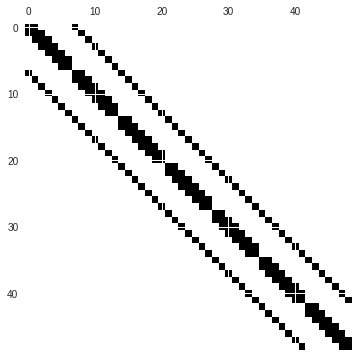

In [ ]:
import matplotlib.pyplot as plt

# plot the sparsity pattern of A
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.spy(A.todense());

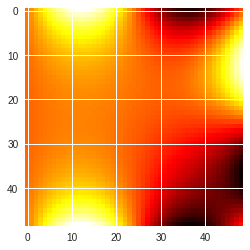

In [ ]:
plt.figure()
plt.imshow(T, cmap=cm.hot)

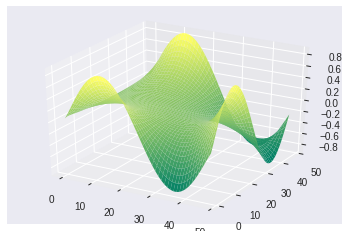

In [ ]:

X, Y = np.meshgrid(range(k), range(k))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax = fig.gca()
ax.plot_surface(X, Y, T, cmap=cm.summer)

In [ ]:

import numpy as np
from scipy.sparse import lil_matrix
import sys

def initA(dim, dense=0):
    No = dim ** 3
    if dense == 0:
        A = lil_matrix((No,No))
    else:
        A = np.zeros((No,) * 2)
    for i in range(0,No):
        ci = i  // dim**2
        cj = (i - ci * dim**2) // dim
        ck = i  %  dim
        curr = (ci * dim + cj) * dim +ck
        A[i, curr] = 4
        
        v = ck - 1
        if v>=0:       
            curr = (ci * dim + cj) * dim + v
            A[i,curr] = -1 
    
        v = ck + 1
        if v<dim:       
            curr = (ci * dim + cj) * dim + v
            A[i,curr] = -1 
            
        v = cj - 1
        if v>=0:       
            curr = (ci * dim + v) * dim + ck
            A[i,curr] = -1
        
        v = cj + 1
        if v<dim:
            curr = (ci * dim + v) * dim + ck
            A[i,curr] = -1
        
        v = ci - 1
        if v>=0:       
            curr = (v * dim + cj) * dim + ck
            A[i,curr] = -1
        
        v = ci + 1
        if v<dim:       
            curr = (v * dim + cj) * dim + ck
            A[i,curr] = -1
            
    return A

In [ ]:
np.asarray(initA(3, True)).shape

Dense


(27, 27)

43


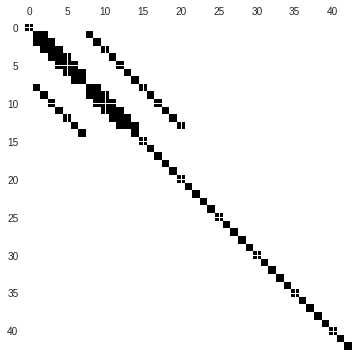

In [ ]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt


def rhs(x, y):
    # Element-wise multiplication
    return np.multiply(x, (x - y)**3)

def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

def problemOneSolverPartTwo(rightHandSide, *args, **kwargs):

    # problemOneSolver solves the poisson equation on the defined domain
# leveraging the poisson equation on the given domain with step
# size of 0.5. Argument rightHandSide is a function pointer to a matlab
# function
    
    # DE Operator Matrix initialized here with specific indices
    D = np.dot(4, np.eye(43))
    # Add -1 to neighbors to specific indices during iterative loop (below)
    row_indices = np.concatenate([[1],[1],[2],[2],[2],[3],[3],[3],[4],[4],[4],
        [5],[5],[5],[6],[6],[6],[7],[7],[8],[8],[8],[9],[9],[9],[9],
        [10],[10],[10],[10],[11],[11],[11],[11],[12],[12],[12],[12],
        [13],[13],[13],[13],[14],[14],[14],[15],[15],[15],[16],[16],
        [16],[16],[17],[17],[17],[17],[18],[18],[18],[18],[19],[19],
        [19],[19],[20],[20],[20],[21],[21],[22],[22],[22],[23],[23],
        [23],[23],[24],[24],[24],[24],[25],[25],[25],[25],[26],[26],
        [26],[27],[27],[27],[28],[28],[28],[28],[29],[29],[29],[29],
        [30],[30],[30],[31],[31],[32],[32],[32],[33],[33],[33],[33],
        [34],[34],[34],[35],[35],[35],[36],[36],[36],[36],[37],[37],
        [37],[38],[38],[38],[39],[39],[39],[39],[40],[40],[40],[41],
        [41],[42],[42],[42],[43],[43]], axis = 0)

    column_indices = np.concatenate([[2],[8],[1],[9],[3],[2],[10],[4],[3],[11],[5],[4],
        [12],[6],[5],[13],[7],[6],[14],[1],[9],[15],[2],[10],[16],[8],[3],
        [11],[17],[9],[4],[12],[18],[10],[5],[13],[19],[11],[6],[14],[20],
        [12],[7],[21],[13],[8],[16],[22],[9],[17],[23],[15],[10],[18],[24],
        [16],[11],[19],[25],[17],[12],[20],[26],[18],[19],[13],[21],[20],[14],
        [15],[23],[27],[16],[24],[28],[22],[17],[25],[29],[23],[18],[26],[30],
        [24],[19],[31],[25],[22],[28],[32],[23],[29],[33],[27],[24],[30],[34],
        [28],[25],[31],[29],[26],[30],[27],[33],[35],[28],[34],[36],[32],[29],
        [37],[33],[32],[36],[38],[33],[37],[39],[35],[34],[40],[36],[35],[39],
        [41],[36],[40],[42],[38],[37],[43],[39],[38],[42],[41],[39],[43],[42],
        [40]], axis = 0)


    for k in range(0, 43):
        D[row_indices[k], column_indices[k]]= -1

#    domain = np.vstack([
#         [1,1,1,1,1,1,1,1,1],
#         [1,1,1,1,1,1,1,1,1],
#         [1,1,1,1,1,1,1,1,1],
#         [1,1,1,1,1,0,0,0,0],
#         [1,1,1,1,1,0,0,0,0],
#         [1,1,1,0,0,0,0,0,0],
#         [1,1,1,0,0,0,0,0,0]
#    ])
#     # Retrieve x and y points that will be evaluated
    y_interior, x_interior = np.nonzero(domain)
    x_interior = np.dot(0.5, x_interior)
    y_interior = np.dot(0.5, y_interior)
#   # Evaluate right hand side at points
    rhsVector = np.dot(0.5 ** 2, rightHandSide(x_interior, y_interior))
#   # Solve the solution vector
    solutionVector = np.linalg.solve(D, rhsVector)
#   # X and Y coordinates
    X, Y = np.meshgrid(np.arange(0, 4.5, 0.5), np.arange(0, 5.5, 0.5))
  
    seven_by_one = np.zeros((7, 1))
    one_by_eleven = np.zeros((1, 11))

    Z = np.concatenate((seven_by_one, domain, seven_by_one), axis  = 1)
    Z = np.concatenate((one_by_eleven, Z, one_by_eleven), axis = 0).T
    
    (i, j) = (Z != 0).nonzero()
    print(np.size(solutionVector))
    for solution in np.arange(0, np.size(solutionVector)).reshape(-1):
      Z[i, j] = solutionVector[i]
     
    import matplotlib.pyplot as plt

    # plot the pattern of Z
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
#     ax.spy(Z);

    ax.spy(D)
    

   # Remove x and y coordinates that are not within the domain or boundary
    arr_temp = np.vstack([[1,1,1],[1,0,1],[1,1,1]])
    convolve2d_temp = np.logical_not(signal.convolve2d(Z, arr_temp, mode='same'))
    zeroIndices = np.where(convolve2d_temp)

    X[zeroIndices] = np.nan
    Y[zeroIndices] = np.nan   
    
    return X, Y, Z


X, Y, Z = problemOneSolverPartTwo(rhs)

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


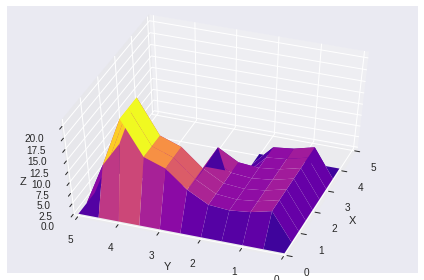

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                       cmap='plasma', edgecolor='none')


ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
#----- Static image
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.tight_layout()
ax.view_init(azim=200, elev=50)
plt.show()

In [ ]:
from IPython.core.display import display, HTML
import json
import numpy as np

def plot3D(X, Y, Z, height=600, xlabel = "X", ylabel = "Y", zlabel = "Z", initialCamera = None):

    options = {
        "width": "100%",
        "style": "surface",
        "showPerspective": True,
        "showGrid": True,
        "showShadow": False,
        "keepAspectRatio": True,
        "height": str(height) + "px"
    }

    if initialCamera:
        options["cameraPosition"] = initialCamera
        
    data = [ {"x": X[y,x], "y": Y[y,x], "z": Z[y,x]} for y in range(X.shape[0]) for x in range(X.shape[1]) ]
    visCode = r"""
       <link href="https://cdnjs.cloudflare.com/ajax/libs/vis/4.21.0/vis.min.css" type="text/css" rel="stylesheet" />
       <script src="https://cdnjs.cloudflare.com/ajax/libs/vis/4.21.0/vis.min.js"></script>
       <div id="pos" style="top:0px;left:0px;position:absolute;"></div>
       <div id="visualization"></div>
       <script type="text/javascript">
        var data = new vis.DataSet();
        data.add(""" + json.dumps(data) + """);
        var options = """ + json.dumps(options) + """;
        var container = document.getElementById("visualization");
        var graph3d = new vis.Graph3d(container, data, options);
        graph3d.on("cameraPositionChange", function(evt)
        {
            elem = document.getElementById("pos");
            elem.innerHTML = "H: " + evt.horizontal + "<br>V: " + evt.vertical + "<br>D: " + evt.distance;
        });
       </script>
    """
    htmlCode = "<iframe srcdoc='"+visCode+"' width='100%' height='" + str(height) + "px' style='border:0;' scrolling='no'> </iframe>"
    display(HTML(htmlCode))


In [ ]:
plot3D(X, Y, Z)